Setup

In [38]:
import numpy as np
import pandas as pd
import os
from itertools import product
import scanpy as sc
import liana as li

import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
# tight layout by default
plt.rcParams.update({'figure.autolayout': True})

from utils import *

In [39]:
li.__version__

'1.0.5'

In [3]:
path = os.path.join('..', '..', 'data', 'slidetags')

In [4]:
[method.method_name for method in li.mt.rank_aggregate.methods]

['CellPhoneDB', 'Connectome', 'log2FC', 'NATMI', 'SingleCellSignalR']

In [5]:
from liana.method import cellphonedb, connectome, cellchat, scseqcomm, singlecellsignalr, natmi, logfc, rank_aggregate, geometric_mean
methods = [cellphonedb, connectome, cellchat, scseqcomm, singlecellsignalr, natmi, logfc, rank_aggregate, geometric_mean]

In [6]:
groupby = 'cell_type'

In [7]:
d = {
     # 'SCP2162': 'mousehippocampus', # NOTE barcodes between metadata and matrix do not match; also very few spatially-matched
     'SCP2167': 'humancortex',
     'SCP2169': 'HumanTonsil',
     'SCP2170': 'mouseembryo',
     'SCP2171': 'HumanMelanomaRNA',
     'SCP2176': 'HumanMelanomaMultiome'
     }

Prep Data & Run LIANA

In [8]:
for k, v in d.items():
    adata = sc.read_10x_mtx(os.path.join(path, f'{k}/expression/counts/'))
    spatial = pd.read_csv(os.path.join(path, f"{k}/cluster/{v}_spatial.csv")).iloc[1:].set_index("NAME")
    
    print(k, v, adata.shape)
    
    # NOTE: keep only cells that are in the spatial data
    adata = adata[adata.obs.index.isin(spatial.index)]
    adata.obs = adata.obs.merge(spatial, left_index=True, right_index=True)
    # remove _ from cell types
    adata.obs['cell_type'] = adata.obs['cell_type'].str.replace('_', '-')
    
    adata.obsm = {}
    adata.obsm['spatial'] = adata.obs[['X', 'Y']].values.astype(np.float32)
    
    # Filter and normalize
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    
    adata.layers['raw'] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    
    if v.__contains__("mouse"):
        resource_name = 'mouseconsensus'
    else:
        resource_name = 'consensus'
    
    # Run Methods
    for method in methods:
        adata.uns[method.method_name] = method(adata,
                                               groupby=groupby,
                                               use_raw=False,
                                               verbose=False,
                                               n_perms=100,
                                               n_jobs=10,
                                               inplace=False,
                                               resource_name=resource_name,
                                               )
    
    adata.write_h5ad(os.path.join(path, f"{k}adata.h5ad"))

SCP2167 humancortex (14165, 36601)


... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'cell_type' as categorical
... storing 'feature_types' as categorical


SCP2169 HumanTonsil (9360, 36601)


... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'cell_type' as categorical
... storing 'feature_types' as categorical


SCP2170 mouseembryo (9037, 32285)


... storing 'cell_type' as categorical
... storing 'feature_types' as categorical


SCP2171 HumanMelanomaRNA (6466, 36601)


... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'cell_type' as categorical
... storing 'feature_types' as categorical


SCP2176 HumanMelanomaMultiome (5704, 36601)


... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'cell_type' as categorical
... storing 'feature_types' as categorical


Generate Truth

In [9]:
for k, v in d.items():
    adata = sc.read_h5ad(os.path.join(path, f"{k}/adata.h5ad"))
    
    if v.__contains__("mouse"):
        resource_name = 'mouseconsensus'
    else:
        resource_name = 'consensus'
    
    # Run LR
    li.ut.spatial_neighbors(adata, bandwidth=150, cutoff=0.1, set_diag=True)
    li.mt.lr_bivar(adata, 
               function_name="morans",
               inplace=True,
               use_raw=False, 
               n_perms=0,
               expr_prop=0.05,
               verbose=True,
               mask_negatives=True,
               resource_name=resource_name
               )
    lrdata = adata.obsm['local_scores']
    lrdata.write_h5ad(os.path.join(path, f"{k}/lrdata.h5ad"))
    
    # Run CP; NOTE: I'm currently discarding autocrine, and only evaluating para/ortho
    ctdata = onehot_groupby(adata, groupby='cell_type')
    interactions = list(product(ctdata.var.index, ctdata.var.index))
    
    li.mt.lr_bivar(ctdata, 
               function_name="morans",
               inplace=True,
               use_raw=False,
               expr_prop=0,
               n_perms=0,
               verbose=True,
               mask_negatives=True,
               interactions=interactions,
               )
    cpdata = ctdata.obsm['local_scores']
    cpdata.write_h5ad(os.path.join(path, f"{k}/cpdata.h5ad"))

Using resource `consensus`.
Using `.X`!
... storing 'ligand' as categorical
... storing 'receptor' as categorical
/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
Using provided `interactions`.
Using `.X`!
Make sure that normalized counts are passed!
Removing 7 self-interactions
... storing 'ligand' as categorical
... storing 'receptor' as categorical
Using resource `consensus`.
Using `.X`!
... storing 'ligand' as categorical
... storing 'receptor' as categorical
/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
Using provided `interactions`.
Using `.X`!
Make sure that normalized counts are passed!
Removing 13 self-interactions
... storing 'ligand' as categorical
... storing 'receptor' as categorical
Using resource `mouseconsensus`.
Using `.X`!
... storing 'ligand' as categorica

Evaluate

In [10]:
scores = li.mt.show_methods()
prop_range = [0.01, 0.05, 0.1, 0.2, 0.5]
eval_results = pd.DataFrame(columns=['Dataset', 'Method', 'Score', 'AUROC', 'Odds'])

In [11]:
# Run Methods & Evaluate
for k, v in d.items():
    adata = sc.read_h5ad(os.path.join(path, f"{k}/adata.h5ad"))
    lrdata = sc.read_h5ad(os.path.join(path, f"{k}/lrdata.h5ad"))
    cpdata = sc.read_h5ad(os.path.join(path, f"{k}/cpdata.h5ad"))
    
    for method in methods:
        method_name = method.method_name        
        score_keys = scores[scores['Method Name'] == method.method_name]
        lr_res = adata.uns[method_name].copy()

        score_keys = score_keys[['Magnitude Score', 'Specificity Score']].values[0]
        # if None in score_keys, remove it
        score_keys = [s for s in score_keys if s is not None]

        for score_key in score_keys:
            lr_res = li.method.process_scores(lr_res, score_key=score_key)
            gt = join_pred_truth(lr_res, lrdata, cpdata)
            
            odds = [odds_ratio(gt, score_key=score_key, top_prop=prop) for prop in prop_range]
            auroc = calc_auroc(gt, score_key=score_key, show_plot=False)
            
            eval_results.loc[len(eval_results)] = [v, method_name, score_key, auroc, odds]

ratio: 0.12637190341799936, shape:(9567, 17)
ratio: 0.12637190341799936, shape:(9567, 17)
ratio: 0.12637190341799936, shape:(9567, 19)
ratio: 0.12637190341799936, shape:(9567, 19)
ratio: 0.12637190341799936, shape:(9567, 18)
ratio: 0.12637190341799936, shape:(9567, 18)
ratio: 0.12637190341799936, shape:(9567, 18)
ratio: 0.12637190341799936, shape:(9567, 17)
ratio: 0.12637190341799936, shape:(9567, 19)
ratio: 0.12637190341799936, shape:(9567, 19)
ratio: 0.12637190341799936, shape:(9567, 18)
ratio: 0.12637190341799936, shape:(9567, 20)
ratio: 0.12637190341799936, shape:(9567, 20)
ratio: 0.12637190341799936, shape:(9567, 17)
ratio: 0.12637190341799936, shape:(9567, 17)
ratio: 0.208644783880403, shape:(21539, 17)
ratio: 0.208644783880403, shape:(21539, 17)
ratio: 0.208644783880403, shape:(21539, 19)
ratio: 0.208644783880403, shape:(21539, 19)
ratio: 0.208644783880403, shape:(21539, 18)
ratio: 0.208644783880403, shape:(21539, 18)
ratio: 0.208644783880403, shape:(21539, 18)
ratio: 0.20864478

In [12]:
eval_results.to_csv("evals_results.csv")

Visualize

In [91]:
res = pd.read_csv("evals_results.csv")

In [92]:
# replace expr_prod with Product* when Method is Connectome
res.loc[(res['Score'] == 'expr_prod') & (res['Method'] == 'Connectome'), 'Score'] = 'Product*'
# # filter Connectome when using Product*
# res = res[~((res['Score'] == 'Product*') & (res['Method'] == 'Connectome'))]

In [93]:

# Assuming 'res' is already loaded as a pandas DataFrame
# Replace underscores with spaces and title case 'Score'
res['Score'] = res['Score'].str.replace('_', ' ').str.title()

# Convert 'Score' to a categorical type with ordered categories
score_order = res.sort_values("Method")['Score'].unique()
res['Score'] = pd.Categorical(res['Score'], categories=score_order, ordered=True)

/tmp/ipykernel_538054/1488181738.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


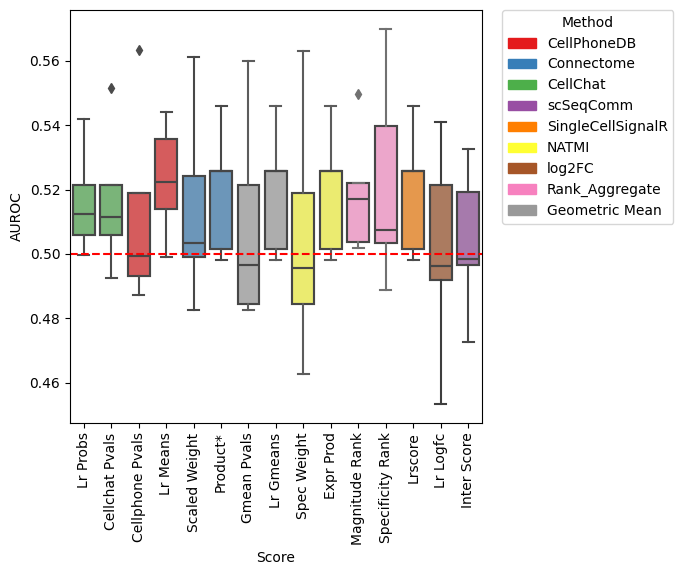

In [94]:
# Set the figure size
plt.figure(figsize=(7, 6))  # This is in inches

# Create a color palette
palette = sns.color_palette("Set1", n_colors=res['Method'].nunique())

# Plot each 'Method' group with a different color
for i, method in enumerate(res['Method'].unique()):
    subset = res[res['Method'] == method]
    sns.boxplot(x='Score', y='AUROC', data=subset, color=palette[i], boxprops=dict(alpha=.8))

# Plot the outlines without filling color
sns.boxplot(x='Score', y='AUROC', data=res, showcaps=False, boxprops=dict(facecolor='None'),
            showfliers=False, whiskerprops=dict(color='None'))

# Set the y-axis labels to two decimals
plt.gca().set_yticklabels(['{:.2f}'.format(x) for x in plt.gca().get_yticks()])



# Draw a horizontal line at y=0.50
plt.axhline(y=0.50, color='red', linestyle='dashed', linewidth=1.5)

# Rotate the x-axis labels
plt.xticks(rotation=90)

# Remove the title and subplot title
plt.title('')
plt.suptitle('')

methods = res['Method'].unique()
colors = plt.cm.Set1(range(len(methods)))

# Create a list of patches for the legend
legend_patches = [mpatches.Patch(color=colors[i], label=method) for i, method in enumerate(methods)]
plt.legend(handles=legend_patches, title='Method', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


# Tight layout often improves the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
